In [1]:
%load_ext autoreload
%autoreload 2

## Basic imports

In [2]:
import pandas as pd
import numpy as np

### Graphql imports

In [3]:
import asyncio

from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport

### Visualisation imports

In [4]:
# import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px


## Read data

In [5]:
url = "https://public-api.defiyield.app/graphql/"
header = {"X-Api-Key": "bad7014e-3fd4-473a-b981-1a5c2dd2d72e"}

rekt_query_str = """
        query {
            rekts(
                orderBy: {
                fundsLost: desc
                }
            ) {
                id, 
                projectName, 
                date, 
                description,
                fundsLost, 
                fundsReturned,
                category, 
                issueType,
                chaindIds,
                token{
                  name
                }
            }
        }
        """

chains_query_str = """
        query {
            chains {
                id,
                absoluteChainId,
                abbr,
                name,
                type
            }
        }
        """

In [6]:
async def get_data(query_str):

    transport = AIOHTTPTransport(url=url, headers=header)

    # Using `async with` on the client will start a connection on the transport
    # and provide a `session` variable to execute queries on this connection
    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:

        # Execute single query
        query = gql(query_str)
        return await session.execute(query)


rekt_df = await get_data(rekt_query_str)
rekt_df = pd.DataFrame(rekt_df['rekts'])

chains_df = await get_data(chains_query_str)
chains_df = pd.DataFrame(chains_df['chains']).set_index('id')

## Clean data

In [7]:
# rekt_df = pd.DataFrame(result['rekts'], dtype={'fundsLost': 'float'})
rekt_df['fundsLost'] = pd.to_numeric(rekt_df['fundsLost'])
rekt_df['fundsReturned'] = pd.to_numeric(rekt_df['fundsReturned'])
rekt_df['date'] = pd.to_datetime(rekt_df['date'])

rekt_df['chaindId'] = rekt_df['chaindIds'].apply(lambda x: None if len(x) == 0 else x[0])
rekt_df['tokenName'] = rekt_df['token'].apply(lambda x: None if x['name'] == None else x['name'].split(',')[0])
rekt_df['groupedDate'] = rekt_df['date'].apply(lambda x: x.replace(day=1)) 

## Merge dataframes

In [8]:
df = pd.merge(rekt_df, chains_df[['name']].rename(columns={'name': 'chainName'}), left_on=['chaindId'], right_index=True)

## Visualisation

In [9]:
# We have one outlier let's remove it for better visualisation
mask = df['fundsLost'] < 1e10
final_df = df[mask].copy()

In [20]:
date_filter_dict = dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=2,
                     label="2y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        type="date"
    )

### Cumulative Lost & Recovered Funds

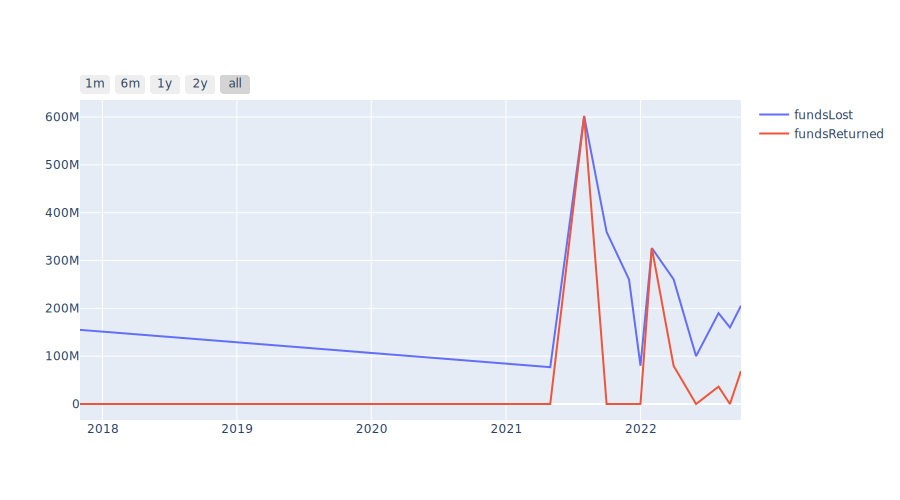

In [53]:
groupby_col = 'groupedDate'

grouped = final_df.groupby(groupby_col)[['fundsLost', 'fundsReturned']].sum()

fig = go.Figure()
fig.add_trace(go.Scatter(x=grouped.index, y=grouped['fundsLost'],
                    mode='lines',
                    name='fundsLost'))

fig.add_trace(go.Scatter(x=grouped.index, y=grouped['fundsReturned'],
                    mode='lines',
                    name='fundsReturned'))

# Add range slider
fig.update_layout(xaxis=date_filter_dict)

fig.show('svg', width=900)

### Funds Lost by Blockchain

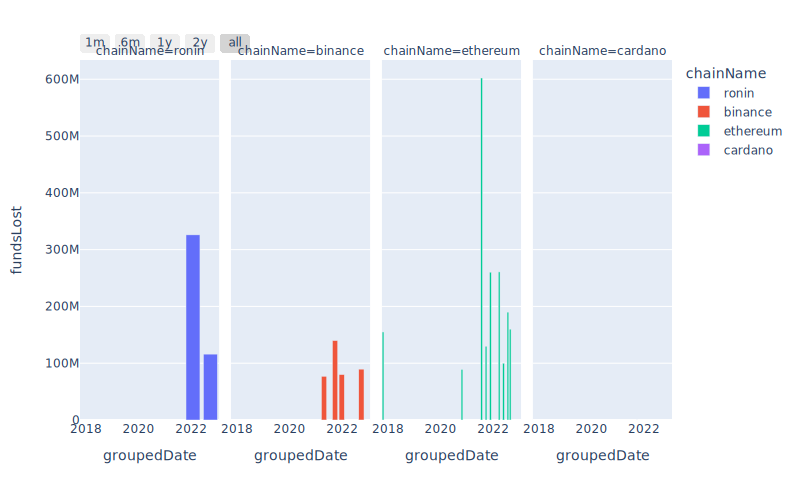

In [54]:
groupby_col = ['groupedDate', 'chainName']

grouped = pd.DataFrame(final_df.groupby(groupby_col)[['fundsLost', 'fundsReturned']].sum())
grouped.reset_index(inplace=True)
fig = px.bar(grouped, x='groupedDate', y="fundsLost", 
             color="chainName", 
             facet_col='chainName', 
             barmode='relative', 
             category_orders={'chainName': ['ronin', 'binance', 'ethereum', 'cardano']})
fig.update_layout(xaxis=date_filter_dict)

# fig.show()
fig.show('svg', width=800)

### Funds Lost by Token

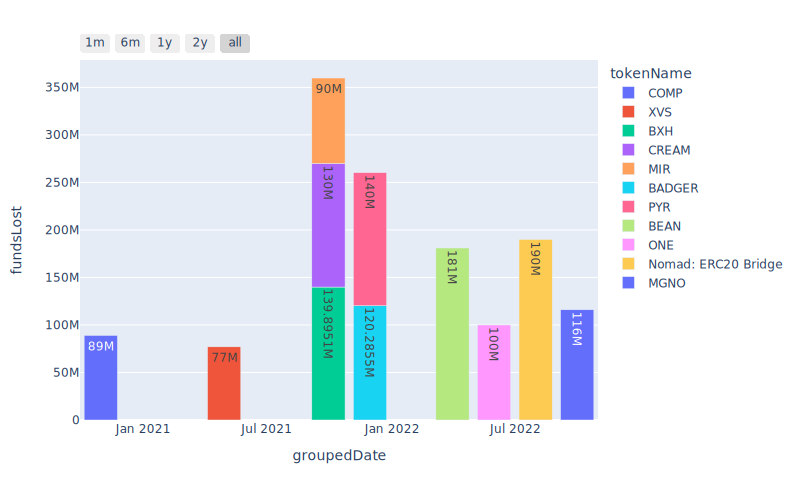

In [56]:
groupby_col = ['groupedDate', 'tokenName']

grouped = pd.DataFrame(final_df.groupby(groupby_col)[['fundsLost', 'fundsReturned']].sum())
grouped.reset_index(inplace=True)
fig = px.bar(grouped, x='groupedDate', y="fundsLost", color="tokenName", 
             text_auto=True)
fig.update_layout(xaxis=date_filter_dict)

# fig.show()
fig.show('svg', width=800)

### Funds Lost by Category

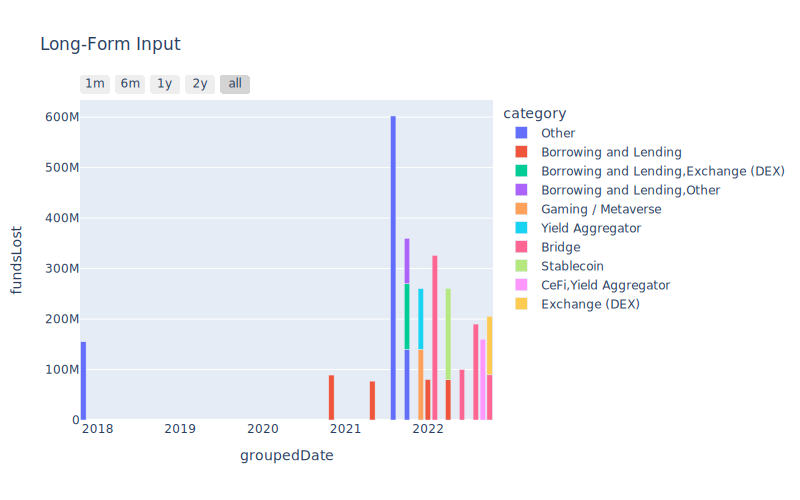

In [57]:
groupby_col = ['groupedDate', 'category']

grouped = pd.DataFrame(final_df.groupby(groupby_col)[['fundsLost', 'fundsReturned']].sum())
grouped.reset_index(inplace=True)
fig = px.bar(grouped, x='groupedDate', y="fundsLost", color="category", title="Long-Form Input")
fig.update_layout(xaxis=date_filter_dict)

# fig.show()
fig.show('svg', width=800)

### Funds Lost by Issues

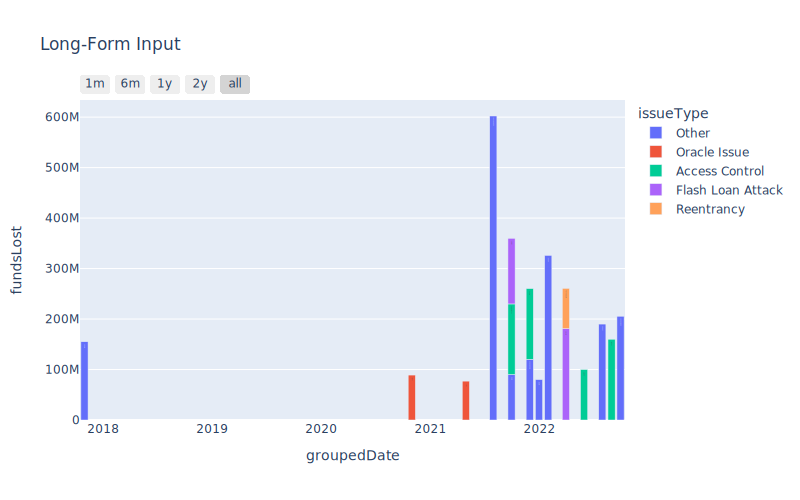

In [58]:
groupby_col = ['groupedDate', 'issueType']

grouped = pd.DataFrame(final_df.groupby(groupby_col)[['fundsLost', 'fundsReturned']].sum())
grouped.reset_index(inplace=True)
fig = px.bar(grouped, x='groupedDate', y="fundsLost", 
             color="issueType", title="Long-Form Input", text_auto=True)
fig.update_layout(xaxis=date_filter_dict)

# fig.show()
fig.show('svg', width=800)